## RESEARCH PROJECT - SPEECH EMOTION RECOGNITION

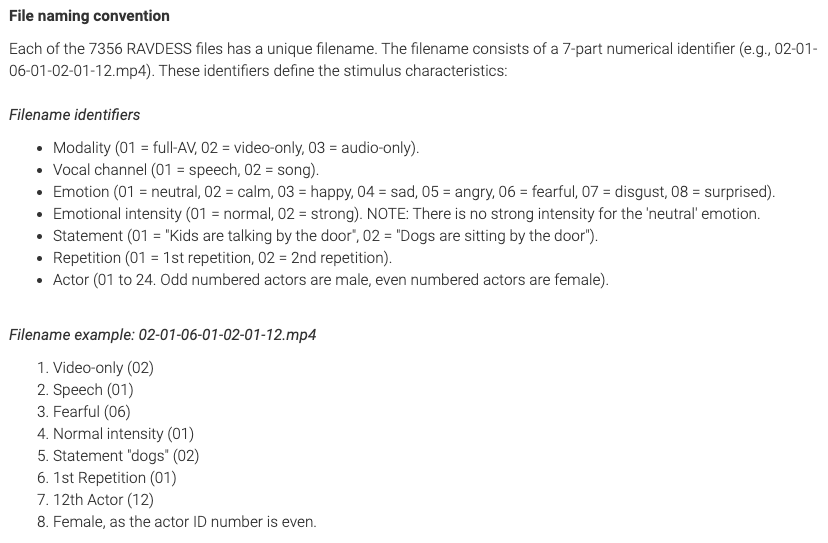

### IMPORT LIBRARIRES

In [32]:
import os
import numpy as np
import pandas as pd
import librosa as lib
import librosa.display 

import matplotlib.pyplot as plt
import seaborn as sns

import IPython.display as ipd 

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import activations

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping

import pydotplus as pyd
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [33]:
path = "/Users/saad/Saad/Education/Ryerson/MRP/Dataset/Audio_Speech_Actors_01-24/ALL"
path_fr = "/Users/saad/Saad/Education/Ryerson/MRP/Dataset/French Dataset/CaFE_48k/ALL_FR"
#file_list = os.listdir(path)
#file_list_fr = os.listdir(path_fr)
#file_list_fr[0]

### READ FILES

In [34]:
#READ ENGLISH FILES

files = []
modality =[]
vocal =[]
emotion =[]
intensity =[]
statement =[]
repetition =[]
actor =[]
gender = []
time = []
audio_data = []
sr = []

max_row = 0
max_col = 0
min_row = 1000
min_col = 1000

n_fft = 2048
hop_length = 512
n_mels = 200

for file_name in file_list:
    file_path = path+'/'+file_name
    mod, voc, emo, inten, state, repe, act = file_name.split('-')
    act = act.split('.')[0]
    
    if emo != '02':
        #store metadata
        files.append(file_name)
        modality.append(mod)
        vocal.append(voc)
        #emotion.append(emo)
        intensity.append(inten)
        statement.append(state)
        repetition.append(repe)
        actor.append(act)

        if (emo == '01'):
            emotion.append('neutral')
        elif (emo == '03'):
            emotion.append('happy')
        elif (emo == '04'):
            emotion.append('sad')
        elif (emo == '05'):
            emotion.append('angry')
        elif (emo == '06'):
            emotion.append('fearful')
        elif (emo == '07'):
            emotion.append('disgust')
        elif (emo == '08'):
            emotion.append('surprised')

        if (int(act) % 2 == 0):
            gender.append(1) #female
        else:
            gender.append(2) #male

        audio, sfreq = lib.load(file_path, sr=44100,offset=0.5,duration = 3.5)
        time_line = np.arange(0,len(audio)) / sfreq
        time.append(time_line)
        audio_data.append(audio)
        sr.append(sfreq)

        #mfccs = lib.feature.mfcc(y=audio,sr=sfreq,n_mfcc=25)
        mfccs = librosa.feature.mfcc(y=audio, sr=sfreq, n_mfcc=13)
        mel_spec = lib.feature.melspectrogram(audio, sr=sfreq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_DB = lib.power_to_db(mel_spec, ref=np.max)

        if (S_DB.shape[0] > max_row):
            max_row = S_DB.shape[0]

        if (S_DB.shape[1] > max_col):
            max_col = S_DB.shape[1]

        if (S_DB.shape[0] < min_row):
            min_row = S_DB.shape[0]

        if (S_DB.shape[1] < min_col):
            min_col = S_DB.shape[1]
            
        
print("DONE !")

#S0 = librosa.feature.melspectrogram(X0, sr=sample_rate0, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
#S_DB0 = librosa.power_to_db(S0, ref=np.max)       

DONE !


In [35]:
#READ FRENCH FILES
files_fr = []
emotion_fr =[]
audio_data_fr = []
sr_fr = []
time_fr = []

n_fft = 2048
hop_length = 512
n_mels = 200

for file_name in file_list_fr:
    file_path = path_fr+'/'+file_name
    #print(file_name)
    
    if file_name != '.DS_Store':
        act, emo, inten, state = file_name.split('-')
        #act = act.split('.')[0]

        #store metadata
        files_fr.append(file_name)

        if (emo == 'C'):
            emotion_fr.append('angry')
        elif (emo == 'D'):
            emotion_fr.append('disgust')
        elif (emo == 'J'):
            emotion_fr.append('happy')
        elif (emo == 'N'):
            emotion_fr.append('neutral')
        elif (emo == 'P'):
            emotion_fr.append('fearful')
        elif (emo == 'S'):
            emotion_fr.append('surprised')
        elif (emo == 'T'):
            emotion_fr.append('sad')

        audio, sfreq = lib.load(file_path, sr=44100,offset=0.5,duration = 3.5)
        time_line = np.arange(0,len(audio)) / sfreq
        time_fr.append(time_line)
        audio_data_fr.append(audio)
        sr_fr.append(sfreq)

        #mfccs = lib.feature.mfcc(y=audio,sr=sfreq,n_mfcc=25)
        mfccs = librosa.feature.mfcc(y=audio, sr=sfreq, n_mfcc=13)
        mel_spec = lib.feature.melspectrogram(audio, sr=sfreq, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
        S_DB = lib.power_to_db(mel_spec, ref=np.max)

print("DONE !")

DONE !


In [36]:
print(max_row)
print(max_col)
print(min_row)
print(min_col)
print(len(files))
mfcc_np = np.zeros((len(files), max_row, max_col))
mfcc_np_fr = np.zeros((len(files_fr), max_row, max_col))
print(mfcc_np.shape)
print(mfcc_np_fr.shape)
#time = np.arange(0,max_length) / 22050.0
#time

200
302
200
213
2076
(2076, 200, 302)
(504, 200, 302)


In [37]:
df_files = pd.DataFrame({'file_name': files, 'emotion': emotion, 'intensity': intensity, 
                         'actor': actor, 'gender': gender, 'sfreq': sr, 'audio': audio_data })

df_files_fr = pd.DataFrame({'file_name': files_fr, 'emotion': emotion_fr, 'sfreq': sr_fr, 'audio': audio_data_fr })
print(df_files.shape)

(2076, 7)


In [38]:
df_files.emotion.unique()

array(['fearful', 'angry', 'happy', 'surprised', 'neutral', 'sad',
       'disgust'], dtype=object)

In [39]:
df_files_fr.emotion.unique()

array(['fearful', 'sad', 'angry', 'surprised', 'happy', 'disgust',
       'neutral'], dtype=object)

### DATA EXPLORATION

Text(0, 0.5, 'Disgust - Hz')

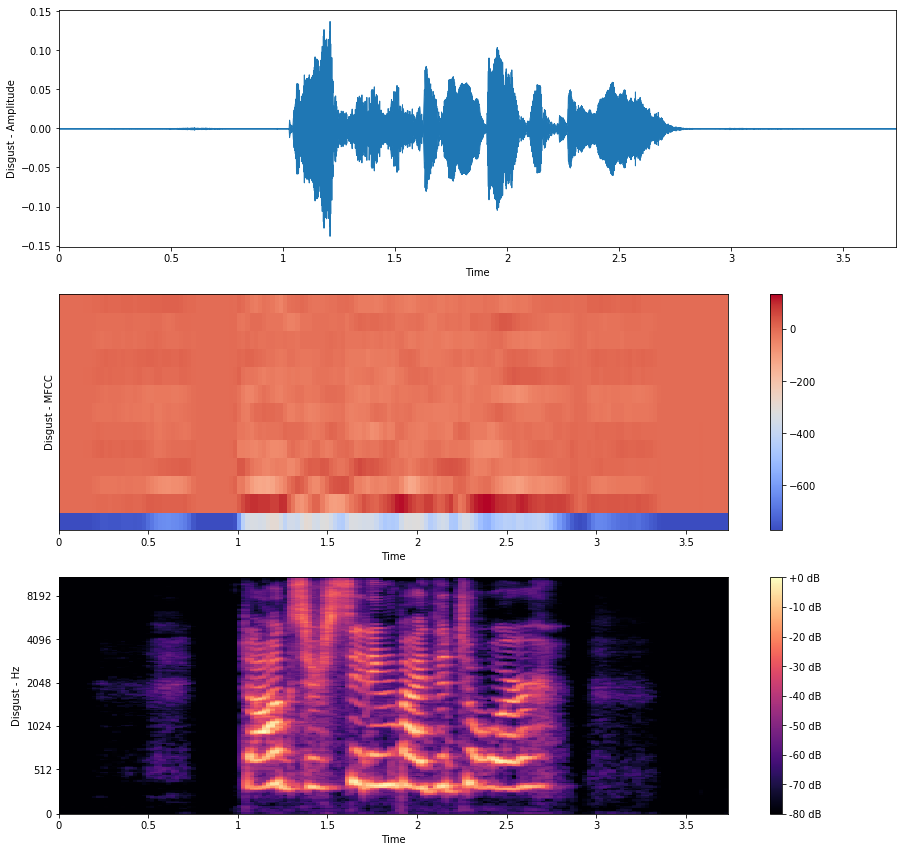

In [40]:
#ANALYZING WAVEFORM
file_path0 = path+'/'+files[0]

X0, sample_rate0 = librosa.load(file_path0)

mfcc0 = librosa.feature.mfcc(y=X0, sr=sample_rate0, n_mfcc=13)

#n_fft = 2048
#hop_length = 512
#n_mels = 128

S0 = librosa.feature.melspectrogram(X0, sr=sample_rate0, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
S_DB0 = librosa.power_to_db(S0, ref=np.max)

# audio wave
plt.figure(figsize=(15, 20))

plt.subplot(4,1,1)
#plt.legend(loc="upper right")
plt.ylabel('Disgust - Amplitude')
librosa.display.waveplot(X0, sr=sample_rate0)
#plt.title('Audio sampled at 44100 hrz')

plt.subplot(4,1,2)
#plt.legend(loc="upper right")
librosa.display.specshow(mfcc0, x_axis='time')
plt.colorbar()
plt.ylabel('Disgust - MFCC')

plt.subplot(4,1,3)
librosa.display.specshow(S_DB0, sr=sample_rate0, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');
plt.ylabel('Disgust - Hz')

In [41]:
S_DB0

array([[-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -80.     ],
       [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -78.12349],
       [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -80.     ],
       ...,
       [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -80.     ],
       [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -80.     ],
       [-80.     , -80.     , -80.     , ..., -80.     , -80.     ,
        -80.     ]], dtype=float32)

In [42]:
S_DB0.shape

(200, 161)

### PREPROCESSING DATA

In [43]:
# EXTRACT ONLY AUDIO DATA AND LABELS FROM DATAFRAME

audio_list = []
audio_list_fr = []

for file_name in file_list:
    file_path = path+'/'+file_name
    mod, voc, emo, inten, state, repe, act = file_name.split('-')
    act = act.split('.')[0]
    
    if emo != '02':     
        #print(result.shape)
        #X, sample_rate = librosa.load(path,duration=2.5,sr=44100,offset=0.5)
        X, sample_rate = lib.load(file_path,sr=44100,offset=0.5,duration = 3.5)
        audio_list.append(X)
    
for file_name in file_list_fr:
    file_path = path_fr+'/'+file_name
    
    if file_name != '.DS_Store':
        #print(result.shape)
        #X, sample_rate = librosa.load(path,duration=2.5,sr=44100,offset=0.5)
        X, sample_rate = lib.load(file_path,sr=44100,offset=0.5,duration = 3.5)
        audio_list_fr.append(X)
    

only_audio_array = np.asarray(audio_list)
only_audio_array_fr = np.asarray(audio_list_fr)

#df_features = df_final.drop(['file_name', 'emotion','intensity','actor'], axis=1)
df_label = df_files[['emotion']].copy()
df_label_fr = df_files_fr[['emotion']].copy()

le = preprocessing.LabelEncoder()
df_label.emotion = le.fit_transform(df_label.emotion)
df_label_fr.emotion = le.transform(df_label_fr.emotion)

print(only_audio_array.shape)
le.classes_
# Check a few records to make sure its processed successfully
#print(len(df_adjusted_audio_mfcc))

(2076,)


array(['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad',
       'surprised'], dtype=object)

In [44]:
# Split between train and test AND PERFORM DATA AUGMENTATION -----------------------------------

random_num = 42
X_train, X_test, y_train, y_test = train_test_split((only_audio_array)
                                                    , df_label
                                                    , test_size=0.2
                                                    , shuffle=True
                                                    , random_state=random_num)
print("FIRST ARRAY SHAPES")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

enc = OneHotEncoder()
label_onehot_train = enc.fit_transform(y_train).toarray()
label_onehot_test = enc.fit_transform(y_test).toarray()
print(enc.categories_)

#AUGMENT DATA WITH NOISE -----------------------------------
def manipulate_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

a_list = [1, 2]
distribution = [0.0, 1.0]

manipulated_audio = []
manipulated_onehot_label = []

for i in range(len(X_train)):
    random_number = np.random.choice(a_list, p = distribution)
    if random_number == 2:
        data = manipulate_noise(X_train[i],0.008)
        manipulated_audio.append(data)
        manipulated_onehot_label.append(label_onehot_train[i])
        
a_list = [1, 2]
distribution = [0.0, 1.0]

manipulated_audio2 = []
manipulated_onehot_label2 = []

for i in range(len(X_train)):
    random_number = np.random.choice(a_list, p = distribution)
    if random_number == 2:
        data = manipulate_noise(X_train[i],0.008)
        manipulated_audio2.append(data)
        manipulated_onehot_label2.append(label_onehot_train[i])
    
    
#AUGMENT DATA WITH PITCH -----------------------------------
def manipulate_pitch(data):
    return lib.effects.pitch_shift(data, sr=44100, n_steps=4)
    
a_list = [1, 2]
distribution = [0.1, 0.9]

manipulated_audio_pitch = []
manipulated_onehot_label_pitch = []

#y_train_array = np.array(y_train)
for i in range(len(X_train)):
    random_number = np.random.choice(a_list, p = distribution)
    if random_number == 2:
        data = manipulate_pitch(X_train[i])
        manipulated_audio_pitch.append(data)
        manipulated_onehot_label_pitch.append(label_onehot_train[i])
    
#CONCATENATE DATA -----------------------------------
X_train_manu = np.concatenate((X_train,np.asarray(manipulated_audio),
                               np.asarray(manipulated_audio_pitch),
                              np.asarray(manipulated_audio2)),axis = 0)

#y_train_dup = np.concatenate((y_train,y_train,y_train,y_train),axis = 0)
label_onehot_train_manu = np.concatenate((label_onehot_train,np.asarray(manipulated_onehot_label),
                                          np.asarray(manipulated_onehot_label_pitch),
                                         np.asarray(manipulated_onehot_label2)),axis = 0)

print("\nCONCAT ARRAY SHAPES")
print(X_train_manu.shape)
print(X_test.shape)
print(label_onehot_train_manu.shape)
print(label_onehot_test.shape)

#CHANGE DATA TO SPECTOGRAM -----------------------------------
spectogram_list_train = []
for item in X_train_manu:
    mel_spec = lib.feature.melspectrogram(item, sr=44100, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = lib.power_to_db(mel_spec, ref=np.max)

    if S_DB.shape[1] < max_col:
        result = np.zeros((max_row,max_col - S_DB.shape[1]),dtype=float)
        #print(mfccs.shape)
        #print(mfccs)
        a = np.hstack((S_DB,result))
        spectogram_list_train.append(a)
    else:
        spectogram_list_train.append(S_DB)
        
spectogram_array_train = np.asarray(spectogram_list_train)


spectogram_list_test = []
for item in X_test:
    mel_spec = lib.feature.melspectrogram(item, sr=44100, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = lib.power_to_db(mel_spec, ref=np.max)

    if S_DB.shape[1] < max_col:
        result = np.zeros((max_row,max_col - S_DB.shape[1]),dtype=float)
        #print(mfccs.shape)
        #print(mfccs)
        a = np.hstack((S_DB,result))
        spectogram_list_test.append(a)
    else:
        spectogram_list_test.append(S_DB)
        
spectogram_array_test = np.asarray(spectogram_list_test)
    


#DO DATA NORMALIZATION -----------------------------------
mean = np.mean(spectogram_array_train,axis = 0)
std = np.std(spectogram_array_train,axis = 0)

x_train_temp = spectogram_array_train.reshape(spectogram_array_train.shape[0],spectogram_array_train.shape[1]*spectogram_array_train.shape[2])
x_test_temp = spectogram_array_test.reshape(spectogram_array_test.shape[0],spectogram_array_test.shape[1]*spectogram_array_test.shape[2])

scaler = preprocessing.StandardScaler().fit(x_train_temp)

X_train_norm = scaler.transform(x_train_temp) #(X_train - mean)#/std
X_test_norm = scaler.transform(x_test_temp) #(X_test - mean)#/std

X_train_norm_re = X_train_norm.reshape(X_train_norm.shape[0],spectogram_array_train.shape[1],spectogram_array_train.shape[2])
X_test_norm_re = X_test_norm.reshape(X_test_norm.shape[0],spectogram_array_test.shape[1],spectogram_array_test.shape[2])

print("\nNORM ARRAY SHAPES")
print(X_train_norm_re.shape)
print(X_test_norm_re.shape)
print(label_onehot_train_manu.shape)
print(label_onehot_test.shape)

X_test_norm_re_n, X_vald, label_onehot_test_n, y_vald = train_test_split((X_test_norm_re)
                                                    , label_onehot_test
                                                    , test_size=0.1
                                                    , shuffle=True
                                                    , random_state=random_num)

# Check the dataset now 
#X_train[:5]

FIRST ARRAY SHAPES
(1660,)
(416,)
(1660, 1)
(416, 1)
[array([0., 1., 2., 3., 4., 5., 6.])]


/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='


CONCAT ARRAY SHAPES
(6473,)
(416,)
(6473, 7)
(416, 7)

NORM ARRAY SHAPES
(6473, 200, 302)
(416, 200, 302)
(6473, 7)
(416, 7)


In [45]:
# FRENCH DATASET

random_num = 42

#enc = OneHotEncoder()
label_onehot_fr = enc.fit_transform(df_label_fr).toarray()
print(enc.categories_)


#CHANGE DATA TO SPECTOGRAM -----------------------------------
spectogram_list_fr = []
for item in only_audio_array_fr:
    mel_spec = lib.feature.melspectrogram(item, sr=44100, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_DB = lib.power_to_db(mel_spec, ref=np.max)

    if S_DB.shape[1] < max_col:
        result = np.zeros((max_row,max_col - S_DB.shape[1]),dtype=float)
        #print(mfccs.shape)
        #print(mfccs)
        a = np.hstack((S_DB,result))
        spectogram_list_fr.append(a)
    else:
        spectogram_list_fr.append(S_DB)
        
spectogram_array_fr  = np.asarray(spectogram_list_fr)

#DO DATA NORMALIZATION -----------------------------------
x_fr_temp = spectogram_array_fr.reshape(spectogram_array_fr.shape[0],spectogram_array_fr.shape[1]*spectogram_array_fr.shape[2])

X_fr_norm = scaler.transform(x_fr_temp) #(X_train - mean)#/std

X_fr_norm_re = X_fr_norm.reshape(X_fr_norm.shape[0],spectogram_array_fr.shape[1],spectogram_array_fr.shape[2])

print("\nNORM ARRAY SHAPES")
print(X_fr_norm_re.shape)
print(label_onehot_fr.shape)


#RESHAPE FOR SVM 
X_fr_norm_reshape_sk = X_fr_norm_re.reshape(X_fr_norm_re.shape[0],
                                                  X_fr_norm_re.shape[1]*X_fr_norm_re.shape[2])

y_fr_encode_sk = enc.inverse_transform(label_onehot_fr)

y_fr_encode_sk = y_fr_encode_sk.ravel()

print("\SVM ARRAY SHAPES")
print(X_fr_norm_reshape_sk.shape)
print(y_fr_encode_sk.shape)

/Users/saad/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


[array([0., 1., 2., 3., 4., 5., 6.])]

NORM ARRAY SHAPES
(504, 200, 302)
(504, 7)
\SVM ARRAY SHAPES
(504, 60400)
(504,)


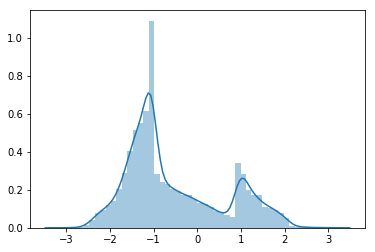

In [46]:
sns.distplot(X_train_norm[1]);

In [47]:
# CONVERT TO ARRAY 
y_train = np.array(y_train)
y_test = np.array(y_test)


### TESTING MODELS - SVM

In [ ]:
#RESHAPE DATA FOR SVM--------------------------
X_train_norm_reshape_sk = X_train_norm_re.reshape(X_train_norm_re.shape[0],
                                                  X_train_norm_re.shape[1]*X_train_norm_re.shape[2])
X_test_norm_reshape_sk = X_test_norm_re.reshape(X_test_norm_re.shape[0],
                                                  X_test_norm_re.shape[1]*X_test_norm_re.shape[2])


y_train_encode_sk = enc.inverse_transform(label_onehot_train_manu)
y_test_encode_sk = enc.inverse_transform(label_onehot_test)

y_train_encode_sk = y_train_encode_sk.ravel()
y_test_encode_sk = y_test_encode_sk.ravel()

print(X_train_norm_reshape_sk.shape)
print(X_test_norm_reshape_sk.shape)
print(y_train_encode_sk.shape)
print(y_test_encode_sk.shape)

In [82]:
#RUN SVM --------------------------

clf = SVC(C = 5, kernel = 'rbf', gamma ='auto', random_state = random_num, degree = 5)
clf.fit(X_train_norm_reshape_sk, y_train_encode_sk)
result_svm = clf.predict(X_test_norm_reshape_sk)

print("accuracy = %s" % (accuracy_score(y_test_encode_sk, result_svm)))

accuracy = 0.7139423076923077


In [83]:
#accuracy on FR dataset
result_svm_fr = clf.predict(X_fr_norm_reshape_sk)
print("accuracy = %s" % (accuracy_score(y_fr_encode_sk, result_svm_fr)))

accuracy = 0.1884920634920635


In [89]:
#save model to directory

import pickle

svm_path = "//Users//saad//Saad//Education//Ryerson//MRP//Models//svm_model_scikit.pkl"
with open(svm_path, 'wb') as file:
    pickle.dump(clf, file)

In [34]:
# Load from file
import pickle
svm_path = "//Users//saad//Saad//Education//Ryerson//MRP//Models//svm_model_scikit.pkl"
with open(svm_path, 'rb') as file:
    pickle_model = pickle.load(file)
    
# Calculate the accuracy score and predict target values
#score = pickle_model.score(Xtest, Ytest)
#print("Test score: {0:.2f} %".format(100 * score))
Ypredict = pickle_model.predict(X_test_norm_reshape_sk)
print("accuracy = %s" % (accuracy_score(y_test_encode_sk, Ypredict)))

#accuracy on FR dataset
result_svm_fr = pickle_model.predict(X_fr_norm_reshape_sk)
print("accuracy french = %s" % (accuracy_score(y_fr_encode_sk, result_svm_fr)))

accuracy = 0.7139423076923077
accuracy french = 0.19047619047619047


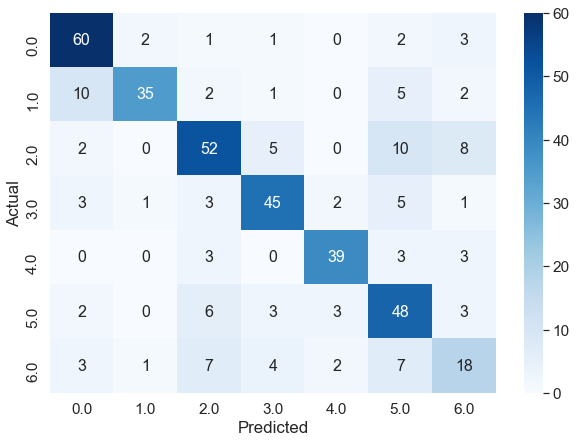

In [35]:
#CONFUSION METRIX

y_true = y_test_encode_sk #label_encoder.inverse_transform(y_test_encode.ravel())
y_pred = Ypredict #label_encoder.inverse_transform(y_pred)
y_pred


data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.axes_style("whitegrid")
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size2

#array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad','surprised'], dtype=object)

### TESTING MODELS - DEEP NN

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 60400)             0         
_________________________________________________________________
dense (Dense)                (None, 200)               12080200  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 70)                7070      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                2

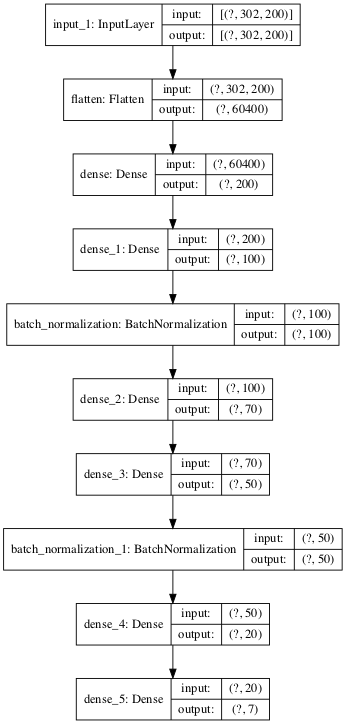

In [27]:

#keras.utils.pydot = pydot

num_of_emotions = len(le.classes_)
num_of_features = X_train_norm_re.shape[2]

model_deep = keras.Sequential()
model_deep.add(keras.Input(shape=(num_of_features,X_train_norm_re.shape[1])))
model_deep.add(layers.Flatten())
model_deep.add(layers.Dense(200, activation="relu"))
model_deep.add(layers.Dense(100, activation="relu"))
model_deep.add(layers.BatchNormalization())
model_deep.add(layers.Dense(70, activation="relu"))
model_deep.add(layers.Dense(50, activation="relu"))
model_deep.add(layers.BatchNormalization())
model_deep.add(layers.Dense(20, activation="relu"))
model_deep.add(layers.Dense(num_of_emotions, activation="softmax"))

model_deep.summary()
# plot model architecture
plot_model(model_deep, show_shapes=True,dpi = 65)#to_file='//Users//saad//Saad//Education//Ryerson//MRP//models//model_deep.png')

In [100]:
#es = EarlyStopping(monitor='val_accuracy', patience=200,restore_best_weights=True,verbose=1)
filepath_to_save = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_deep.hdf5"
checkpoint = ModelCheckpoint(filepath_to_save, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

model_deep.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist_deep = model_deep.fit(X_train_norm_re, label_onehot_train_manu, batch_size=200
                           ,epochs=100, validation_data=(X_vald,y_vald),callbacks=callbacks)

Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 1.9343 - accuracy: 0.2556WARNING:tensorflow:Model was constructed with shape (None, 302, 200) for input Tensor("input_7:0", shape=(None, 302, 200), dtype=float32), but it was called on an input with incompatible shape (None, 200, 302).

Epoch 00001: val_accuracy improved from -inf to 0.14000, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_deep.hdf5
39/39 [==============================] - 33s 851ms/step - loss: 1.9343 - accuracy: 0.2556 - val_loss: 2.2109 - val_accuracy: 0.1400
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 1.6846 - accuracy: 0.3409
Epoch 00002: val_accuracy improved from 0.14000 to 0.32000, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_deep.hdf5
39/39 [==============================] - 8s 213ms/step - loss: 1.6846 - accuracy: 0.3409 - val_loss: 1.8014 - val_accuracy: 0.3200
Epoch 3/100
39/39 [==============================

39/39 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9484
Epoch 00025: val_accuracy did not improve from 0.76000
39/39 [==============================] - 6s 149ms/step - loss: 0.1522 - accuracy: 0.9484 - val_loss: 1.1251 - val_accuracy: 0.6600
Epoch 26/100
39/39 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9556
Epoch 00026: val_accuracy did not improve from 0.76000
39/39 [==============================] - 6s 149ms/step - loss: 0.1319 - accuracy: 0.9556 - val_loss: 1.0597 - val_accuracy: 0.7200
Epoch 27/100
39/39 [==============================] - ETA: 0s - loss: 0.0931 - accuracy: 0.9714
Epoch 00027: val_accuracy did not improve from 0.76000
39/39 [==============================] - 6s 156ms/step - loss: 0.0931 - accuracy: 0.9714 - val_loss: 1.3481 - val_accuracy: 0.6200
Epoch 28/100
39/39 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9765
Epoch 00028: val_accuracy did not improve from 0.76000
39/39 [=========

Epoch 54/100
39/39 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9983
Epoch 00054: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 148ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 1.6777 - val_accuracy: 0.7000
Epoch 55/100
39/39 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9991
Epoch 00055: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 149ms/step - loss: 0.0052 - accuracy: 0.9991 - val_loss: 1.4913 - val_accuracy: 0.7200
Epoch 56/100
39/39 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9986
Epoch 00056: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 146ms/step - loss: 0.0060 - accuracy: 0.9986 - val_loss: 1.5117 - val_accuracy: 0.7400
Epoch 57/100
39/39 [==============================] - ETA: 0s - loss: 0.0359 - accuracy: 0.9882
Epoch 00057: val_accuracy did not improve from 0.80000
39/

39/39 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9953
Epoch 00083: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 147ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 1.8662 - val_accuracy: 0.6800
Epoch 84/100
39/39 [==============================] - ETA: 0s - loss: 0.0071 - accuracy: 0.9980
Epoch 00084: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 148ms/step - loss: 0.0071 - accuracy: 0.9980 - val_loss: 1.5584 - val_accuracy: 0.7400
Epoch 85/100
39/39 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9992
Epoch 00085: val_accuracy did not improve from 0.80000
39/39 [==============================] - 6s 147ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 1.4199 - val_accuracy: 0.7800
Epoch 86/100
39/39 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9987
Epoch 00086: val_accuracy did not improve from 0.80000
39/39 [=========

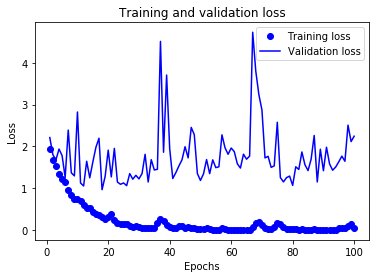

In [101]:
loss = hist_deep.history['loss']
val_loss = hist_deep.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

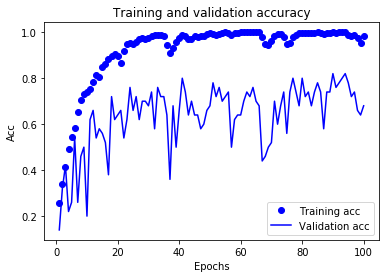

In [102]:
plt.clf()
acc = hist_deep.history['accuracy']
val_acc = hist_deep.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [103]:
score = model_deep.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_deep.metrics_names[1], score[1]*100))

model accuracy: 65.78%


In [36]:
# load weights
filepath_to_save = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_deep.hdf5"
#model_cnn2 = model_cnn1
model_deep.load_weights(filepath_to_save)
model_deep.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print("Created model and loaded weights from file")

# evaluate model on private test set
score = model_deep.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_deep.metrics_names[1], score[1]*100))

Created model and loaded weights from file
model accuracy: 69.65%


### TESTING MODELS - CNN

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 200, 32)           29024     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 32)           3104      
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 32)           128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 66, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 66, 64)            6208      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 66, 64)            12352     
_________________________________________________________________
batch_normalization_3 (Batch (None, 66, 64)           

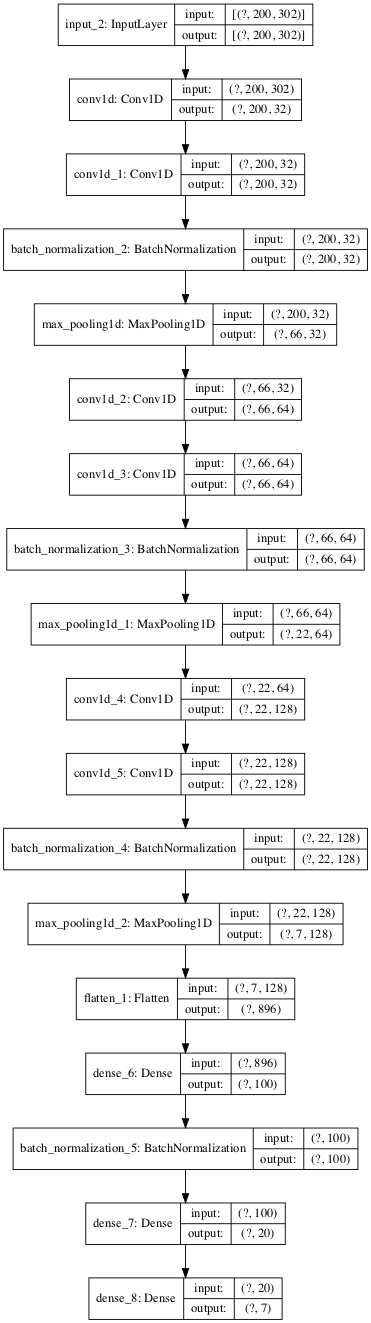

In [28]:
#keras.utils.pydot = pydot

num_filter = 32
kernel_size = 3
maxpool_size = 3

#X_train_reshape = X_train_dup.reshape(X_train_dup.shape[0],X_train_dup.shape[1],1)
#X_test_reshape = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
#X_vald_reshape = X_vald.reshape(X_vald.shape[0],X_vald.shape[1],1)

#num_of_features_reshape = X_train_reshape.shape[1]

model_cnn1 = keras.Sequential()

model_cnn1.add(keras.Input(shape=(X_train_norm_re.shape[1],X_train_norm_re.shape[2])))
model_cnn1.add(layers.Conv1D(num_filter,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.Conv1D(num_filter,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPooling1D(pool_size = maxpool_size))

model_cnn1.add(layers.Conv1D(num_filter*2,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.Conv1D(num_filter*2,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPooling1D(pool_size = maxpool_size))

#model_cnn1.add(layers.Conv1D(num_filter*2,kernel_size, activation="relu",padding="same"))
#model_cnn1.add(layers.Conv1D(num_filter*2,kernel_size, activation="relu",padding="same"))
#model_cnn1.add(layers.BatchNormalization())
#model_cnn1.add(layers.MaxPooling1D(pool_size = maxpool_size))

model_cnn1.add(layers.Conv1D(num_filter*4,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.Conv1D(num_filter*4,kernel_size, activation="relu",padding="same"))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.MaxPooling1D(pool_size = maxpool_size))

model_cnn1.add(layers.Flatten())
model_cnn1.add(layers.Dense(100, activation="relu"))
model_cnn1.add(layers.BatchNormalization())
model_cnn1.add(layers.Dense(20, activation="relu"))
model_cnn1.add(layers.Dense(num_of_emotions, activation="softmax"))

model_cnn1.summary()
# plot model architecture
plot_model(model_cnn1, show_shapes=True,dpi = 65)#to_file='//Users//saad//Saad//Education//Ryerson//MRP//models//model_deep.png')

In [106]:
es = EarlyStopping(monitor='val_accuracy', patience=200,restore_best_weights=True,verbose=1)
filepath_to_save_cnn = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_cnn.hdf5"
checkpoint = ModelCheckpoint(filepath_to_save_cnn, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

model_cnn1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

hist_cnn1 = model_cnn1.fit(X_train_norm_re, label_onehot_train_manu, batch_size=200
                           ,epochs=100, validation_data=(X_test_norm_re,label_onehot_test),callbacks=callbacks)

#model_cnn1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#hist_cnn1 = model_cnn1.fit(X_train_norm_re, label_onehot_train_manu, batch_size=200
                           #, epochs=250, validation_split=0.1)

Epoch 1/100
39/39 [==============================] - ETA: 0s - loss: 1.8931 - accuracy: 0.2784
Epoch 00001: val_accuracy improved from -inf to 0.22000, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_cnn.hdf5
39/39 [==============================] - 17s 439ms/step - loss: 1.8931 - accuracy: 0.2784 - val_loss: 2.0366 - val_accuracy: 0.2200
Epoch 2/100
39/39 [==============================] - ETA: 0s - loss: 1.5974 - accuracy: 0.3879
Epoch 00002: val_accuracy did not improve from 0.22000
39/39 [==============================] - 12s 303ms/step - loss: 1.5974 - accuracy: 0.3879 - val_loss: 1.9731 - val_accuracy: 0.2200
Epoch 3/100
39/39 [==============================] - ETA: 0s - loss: 1.3748 - accuracy: 0.4819
Epoch 00003: val_accuracy did not improve from 0.22000
39/39 [==============================] - 11s 285ms/step - loss: 1.3748 - accuracy: 0.4819 - val_loss: 2.0277 - val_accuracy: 0.2000
Epoch 4/100
39/39 [==============================] - ETA: 0s - loss:

39/39 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9815
Epoch 00027: val_accuracy did not improve from 0.74000
39/39 [==============================] - 10s 248ms/step - loss: 0.0609 - accuracy: 0.9815 - val_loss: 1.5707 - val_accuracy: 0.6400
Epoch 28/100
39/39 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9834
Epoch 00028: val_accuracy did not improve from 0.74000
39/39 [==============================] - 10s 252ms/step - loss: 0.0500 - accuracy: 0.9834 - val_loss: 1.4379 - val_accuracy: 0.6400
Epoch 29/100
39/39 [==============================] - ETA: 0s - loss: 0.0581 - accuracy: 0.9835
Epoch 00029: val_accuracy did not improve from 0.74000
39/39 [==============================] - 10s 251ms/step - loss: 0.0581 - accuracy: 0.9835 - val_loss: 0.8636 - val_accuracy: 0.7400
Epoch 30/100
39/39 [==============================] - ETA: 0s - loss: 0.0480 - accuracy: 0.9868
Epoch 00030: val_accuracy did not improve from 0.74000
39/39 [======

39/39 [==============================] - ETA: 0s - loss: 0.2798 - accuracy: 0.9048
Epoch 00055: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 255ms/step - loss: 0.2798 - accuracy: 0.9048 - val_loss: 1.9803 - val_accuracy: 0.5600
Epoch 56/100
39/39 [==============================] - ETA: 0s - loss: 0.1764 - accuracy: 0.9371
Epoch 00056: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 250ms/step - loss: 0.1764 - accuracy: 0.9371 - val_loss: 1.1673 - val_accuracy: 0.7600
Epoch 57/100
39/39 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9657
Epoch 00057: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 251ms/step - loss: 0.1027 - accuracy: 0.9657 - val_loss: 1.5070 - val_accuracy: 0.7000
Epoch 58/100
39/39 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9876
Epoch 00058: val_accuracy did not improve from 0.80000
39/39 [======

Epoch 84/100
39/39 [==============================] - ETA: 0s - loss: 3.2053e-04 - accuracy: 1.0000
Epoch 00084: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 255ms/step - loss: 3.2053e-04 - accuracy: 1.0000 - val_loss: 0.9620 - val_accuracy: 0.7600
Epoch 85/100
39/39 [==============================] - ETA: 0s - loss: 2.7982e-04 - accuracy: 1.0000
Epoch 00085: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 256ms/step - loss: 2.7982e-04 - accuracy: 1.0000 - val_loss: 0.9592 - val_accuracy: 0.7600
Epoch 86/100
39/39 [==============================] - ETA: 0s - loss: 0.0073 - accuracy: 0.9975
Epoch 00086: val_accuracy did not improve from 0.80000
39/39 [==============================] - 10s 255ms/step - loss: 0.0073 - accuracy: 0.9975 - val_loss: 0.9907 - val_accuracy: 0.7200
Epoch 87/100
39/39 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9847
Epoch 00087: val_accuracy did not impro

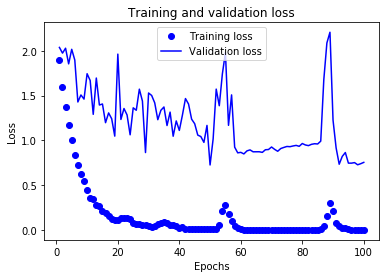

In [107]:
loss = hist_cnn1.history['loss']
val_loss = hist_cnn1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

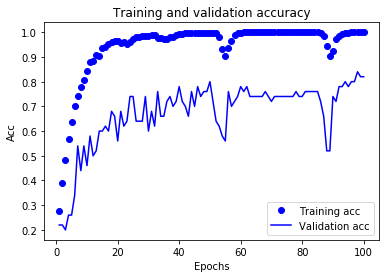

In [108]:
plt.clf()
acc = hist_cnn1.history['accuracy']
val_acc = hist_cnn1.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [109]:
# evaluate model on private test set
score = model_cnn1.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_cnn1.metrics_names[1], score[1]*100))

model accuracy: 66.80%


In [38]:
# load weights
filepath_to_save_cnn = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_cnn.hdf5"
#model_cnn2 = model_cnn1
model_cnn1.load_weights(filepath_to_save_cnn)
model_cnn1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

print("Created model and loaded weights from file")

# evaluate model on private test set
score = model_cnn1.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_cnn1.metrics_names[1], score[1]*100))

Created model and loaded weights from file
model accuracy: 68.02%


### TESTING MODELS - CNN+LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 200, 64)           58048     
_________________________________________________________________
batch_normalization_11 (Batc (None, 200, 64)           256       
_________________________________________________________________
activation_3 (Activation)    (None, 200, 64)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 50, 128)           24704     
_________________________________________________________________
batch_normalization_12 (Batc (None, 50, 128)           512       
_________________________________________________________________
activation_4 (Activation)    (None, 50, 128)          

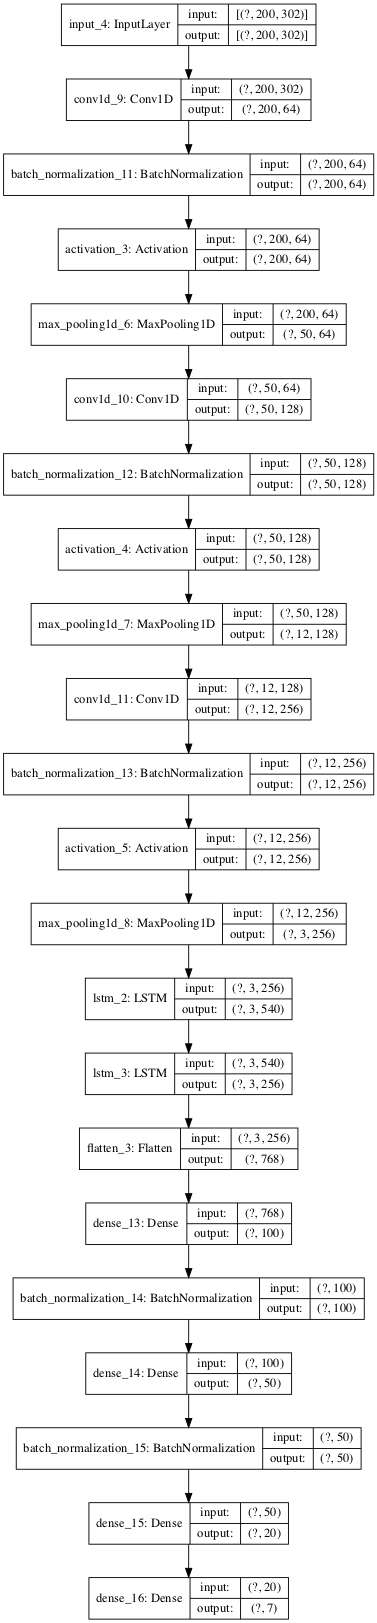

In [48]:
#MODEL BASED ON PAPER

#LOCAL FEATURE LEARNING BLOCK
model_paper = keras.Sequential()
model_paper.add(keras.Input(shape=(X_train_norm_re.shape[1],X_train_norm_re.shape[2])))

model_paper.add(layers.Conv1D(64,3, activation="relu",padding="same",strides = 1))
#model_cnn1.add(layers.Conv1D(num_filter,kernel_size, activation="relu",padding="same"))
model_paper.add(layers.BatchNormalization())
model_paper.add(layers.Activation(activations.elu))
model_paper.add(layers.MaxPooling1D(pool_size = 4))

model_paper.add(layers.Conv1D(128,3, activation="relu",padding="same",strides = 1))
#model_cnn1.add(layers.Conv1D(num_filter,kernel_size, activation="relu",padding="same"))
model_paper.add(layers.BatchNormalization())
model_paper.add(layers.Activation(activations.elu))
model_paper.add(layers.MaxPooling1D(pool_size = 4))

model_paper.add(layers.Conv1D(256,3, activation="relu",padding="same",strides = 1))
#model_cnn1.add(layers.Conv1D(num_filter,kernel_size, activation="relu",padding="same"))
model_paper.add(layers.BatchNormalization())
model_paper.add(layers.Activation(activations.elu))
model_paper.add(layers.MaxPooling1D(pool_size = 4))

model_paper.add(layers.LSTM(540,return_sequences=True))
model_paper.add(layers.LSTM(256,return_sequences=True))

model_paper.add(layers.Flatten())
model_paper.add(layers.Dense(100, activation="relu"))
model_paper.add(layers.BatchNormalization())
model_paper.add(layers.Dense(50, activation="relu"))
model_paper.add(layers.BatchNormalization())
model_paper.add(layers.Dense(20, activation="relu"))
model_paper.add(layers.Dense(num_of_emotions, activation="softmax"))

model_paper.summary()
# plot model architecture
plot_model(model_paper, show_shapes=True,dpi = 65)

In [49]:
es = EarlyStopping(monitor='val_accuracy', patience=200,restore_best_weights=True,verbose=1)
filepath_to_save = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_paper6.hdf5"
checkpoint = ModelCheckpoint(filepath_to_save, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks = [checkpoint]

model_paper.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

hist_paper = model_paper.fit(X_train_norm_re, label_onehot_train_manu, batch_size=200
                           ,epochs=150, validation_data=(X_test_norm_re, label_onehot_test),callbacks=callbacks)


#model_paper.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
#hist_paper = model_paper.fit(X_train_norm_re, label_onehot_train_manu, batch_size=200
 #                          , epochs=250, validation_split=0.1)

Epoch 1/150
33/33 [==============================] - ETA: 0s - loss: 1.7942 - accuracy: 0.2826
Epoch 00001: val_accuracy improved from -inf to 0.19471, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [==============================] - 28s 857ms/step - loss: 1.7942 - accuracy: 0.2826 - val_loss: 1.9435 - val_accuracy: 0.1947
Epoch 2/150
33/33 [==============================] - ETA: 0s - loss: 1.5827 - accuracy: 0.3754
Epoch 00002: val_accuracy improved from 0.19471 to 0.22837, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [==============================] - 18s 538ms/step - loss: 1.5827 - accuracy: 0.3754 - val_loss: 1.8396 - val_accuracy: 0.2284
Epoch 3/150
33/33 [==============================] - ETA: 0s - loss: 1.3851 - accuracy: 0.4642
Epoch 00003: val_accuracy improved from 0.22837 to 0.29808, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [======

Epoch 27/150
33/33 [==============================] - ETA: 0s - loss: 0.0690 - accuracy: 0.9771
Epoch 00027: val_accuracy improved from 0.59615 to 0.61779, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [==============================] - 15s 455ms/step - loss: 0.0690 - accuracy: 0.9771 - val_loss: 1.9739 - val_accuracy: 0.6178
Epoch 28/150
33/33 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9810
Epoch 00028: val_accuracy improved from 0.61779 to 0.62260, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [==============================] - 15s 454ms/step - loss: 0.0626 - accuracy: 0.9810 - val_loss: 1.9949 - val_accuracy: 0.6226
Epoch 29/150
33/33 [==============================] - ETA: 0s - loss: 0.0861 - accuracy: 0.9734
Epoch 00029: val_accuracy improved from 0.62260 to 0.65385, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [

Epoch 55/150
33/33 [==============================] - ETA: 0s - loss: 0.0240 - accuracy: 0.9938
Epoch 00055: val_accuracy did not improve from 0.65385
33/33 [==============================] - 15s 468ms/step - loss: 0.0240 - accuracy: 0.9938 - val_loss: 1.9760 - val_accuracy: 0.6370
Epoch 56/150
33/33 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.9918 
Epoch 00056: val_accuracy did not improve from 0.65385
33/33 [==============================] - 326s 10s/step - loss: 0.0301 - accuracy: 0.9918 - val_loss: 2.0761 - val_accuracy: 0.6418
Epoch 57/150
33/33 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9932
Epoch 00057: val_accuracy improved from 0.65385 to 0.68510, saving model to //Users//saad//Saad//Education//Ryerson//MRP//Models/model_paper6.hdf5
33/33 [==============================] - 18s 534ms/step - loss: 0.0246 - accuracy: 0.9932 - val_loss: 1.9030 - val_accuracy: 0.6851
Epoch 58/150
33/33 [==============================] - ETA: 

Epoch 83/150
33/33 [==============================] - ETA: 0s - loss: 0.0170 - accuracy: 0.9955
Epoch 00083: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 451ms/step - loss: 0.0170 - accuracy: 0.9955 - val_loss: 1.8465 - val_accuracy: 0.6683
Epoch 84/150
33/33 [==============================] - ETA: 0s - loss: 0.0217 - accuracy: 0.9944
Epoch 00084: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 454ms/step - loss: 0.0217 - accuracy: 0.9944 - val_loss: 2.0503 - val_accuracy: 0.6707
Epoch 85/150
33/33 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9964
Epoch 00085: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 460ms/step - loss: 0.0150 - accuracy: 0.9964 - val_loss: 2.3396 - val_accuracy: 0.6202
Epoch 86/150
33/33 [==============================] - ETA: 0s - loss: 0.0218 - accuracy: 0.9944
Epoch 00086: val_accuracy did not improve from 0.69952


Epoch 112/150
33/33 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9975
Epoch 00112: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 469ms/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 2.1531 - val_accuracy: 0.6562
Epoch 113/150
33/33 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9949
Epoch 00113: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 455ms/step - loss: 0.0179 - accuracy: 0.9949 - val_loss: 2.4553 - val_accuracy: 0.6322
Epoch 114/150
33/33 [==============================] - ETA: 0s - loss: 0.0237 - accuracy: 0.9943
Epoch 00114: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 453ms/step - loss: 0.0237 - accuracy: 0.9943 - val_loss: 2.2409 - val_accuracy: 0.6538
Epoch 115/150
33/33 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9966
Epoch 00115: val_accuracy did not improve from 0.69

Epoch 141/150
33/33 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9968
Epoch 00141: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 445ms/step - loss: 0.0177 - accuracy: 0.9968 - val_loss: 2.2653 - val_accuracy: 0.6322
Epoch 142/150
33/33 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9952
Epoch 00142: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 446ms/step - loss: 0.0173 - accuracy: 0.9952 - val_loss: 2.5849 - val_accuracy: 0.6034
Epoch 143/150
33/33 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9985
Epoch 00143: val_accuracy did not improve from 0.69952
33/33 [==============================] - 15s 460ms/step - loss: 0.0078 - accuracy: 0.9985 - val_loss: 2.5856 - val_accuracy: 0.6178
Epoch 144/150
33/33 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9972
Epoch 00144: val_accuracy did not improve from 0.69

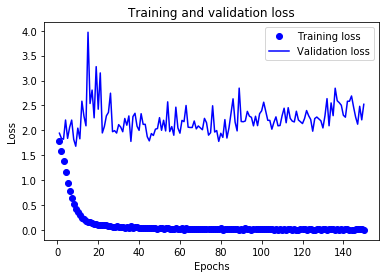

In [50]:
loss = hist_paper.history['loss']
val_loss = hist_paper.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

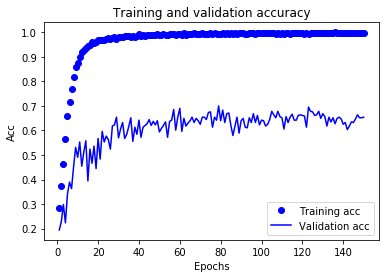

In [51]:
plt.clf()
acc = hist_paper.history['accuracy']
val_acc = hist_paper.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [52]:
# evaluate model on private test set
score = model_paper.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_paper.metrics_names[1], score[1]*100))

model accuracy: 65.38%


In [53]:
# load weights
filepath_to_save = "//Users//saad//Saad//Education//Ryerson//MRP//Models//model_paper5.hdf5"
#model_cnn2 = model_cnn1
model_paper.load_weights(filepath_to_save)
model_paper.compile(loss="categorical_crossentropy", optimizer="RMSprop", metrics=["accuracy"])

print("Created model and loaded weights from file")

# evaluate model on private test set
score = model_paper.evaluate(X_test_norm_re, label_onehot_test, verbose=0)
print ("model %s: %.2f%%" % (model_paper.metrics_names[1], score[1]*100))

Created model and loaded weights from file
model accuracy: 71.15%


In [71]:

# evaluate model on FR test set
score = model_paper.evaluate(X_fr_norm_re, label_onehot_fr, verbose=0)
print ("model %s: %.2f%%" % (model_paper.metrics_names[1], score[1]*100))

model accuracy: 21.63%


In [72]:
def maxposition(A):
   # inbuilt function to find the position of minimum 
   #minposition = A.index(min(A))
   # inbuilt function to find the position of maximum
    A = list(A)
    maxposition = A.index(max(A)) 
   #print ("The maximum is at position::", maxposition + 1) 
   #print ("The minimum is at position::", minposition + 1)
    return maxposition

In [73]:
y_pred = model_paper.predict(X_test_norm_re)

y_pred_adj = []
for row in y_pred:
    y_pred_adj.append(maxposition(row))
    

y_test_encode = enc.inverse_transform(label_onehot_test)
print("accuracy: %s" % (accuracy_score(y_test_encode, y_pred_adj)))
#y_pred_encode = onehot_encoder.inverse_transform(y_pred)
#a = np.array([y_pred])[np.newaxis]
print(y_pred[0])
print(label_onehot_test[0])
print(y_test_encode[0])
print(y_pred_adj[0])

#print(y_test_encode.ravel())

#[0.00567171 0.00214995 0.0185511  0.0095621  0.6694757  0.0544728
# 0.01059681 0.22951978]
#[0. 0. 0. 0. 0. 0. 0. 1.]


accuracy: 0.7115384615384616
[7.2169799e-15 6.3928967e-13 6.2744623e-13 8.4283428e-21 1.0000000e+00
 1.1661659e-14 3.6290649e-22]
[0. 0. 0. 0. 1. 0. 0.]
[4.]
4


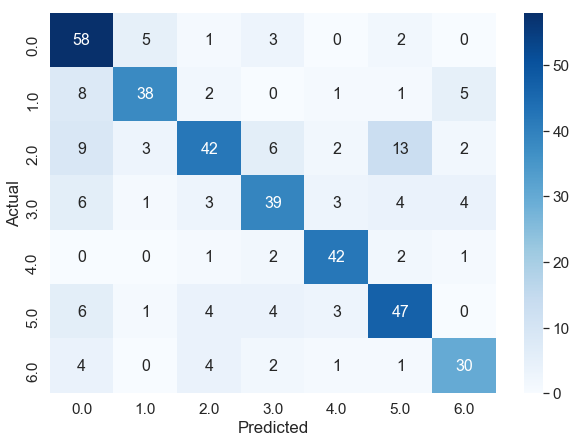

In [75]:
y_true = y_test_encode #label_encoder.inverse_transform(y_test_encode.ravel())
y_pred = y_pred_adj #label_encoder.inverse_transform(y_pred)
y_pred


data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.axes_style("whitegrid")
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size2

#array(['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad','surprised'], dtype=object)